# Determining the market value of a car

A used car sales service is developing an app to attract new customers. There you can find out the market value of your car.
The task is to build a model that can determine the market value of a car based on its characteristics. We have at our disposal data on the technical characteristics, equipment and prices of other cars.

Criteria that are important to the customer:
quality of prediction;
model training time;
model prediction time.
The data is in the autos.csv file.
To assess the quality of models, the target RMSE metric, the target RMSE value is not lower than 2500.

## Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Let's examine the dataset data for gaps and duplicates. Let's evaluate the types of variables, anomalies and the usefulness of features for subsequent predictions of the target feature - the cost of a car.**

In [2]:
data = pd.read_csv('/content/drive/My Drive/projects/car_price_prediction/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**From the information above we can conclude that the following features will not be informative for predicting the target feature from a logical point of view: `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.**

**Because in this case we are simply unloading from the database, and there is no understanding whether each of these cars was sold at the price indicated in the questionnaire or not. The number of photos for each profile is 0, which is also very strange. We will assume that all these cars were sold at the price indicated in the questionnaire and it was the last one at the time the ad was removed due to a successful sale.**

**In a real situation, it would be necessary to check with colleagues responsible for uploading this data whether this is actually the case. And if not, then upload the questionnaires that relate to the cars sold at the price indicated in the questionnaire.**


**Let’s remove uninformative signs below.**

**We also see that there are anomalous values in the following characteristics:**

**`RegistrationYear` - values below 1960 up to 1000 and above 2023;**

**`Price` - values too low, up to 0;**

**`RegistrationMonth` - values 0.**

**`Power` - values 0 and very high values, up to 20,000 hp**

**It will be necessary to analyze these signs in more detail for the number of such anomalous values.**

In [5]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


**Let's see how many objects of the year of manufacture attribute fall into the range below 1970 and above 2023.**

In [6]:
initial_rows = data.shape[0]
data[
    (1970 > data['RegistrationYear']) | (2023 < data['RegistrationYear'])
    ]['RegistrationYear'].count() / data.shape[0]

0.0040720266163236625

**About 0.4%. These ranges include either erroneous data or rare, rare car models. Therefore, we will filter these values from the original data.**

In [7]:
data = data[(1970 <= data['RegistrationYear']) & (data['RegistrationYear'] <= 2023)]
data.shape[0] / initial_rows

0.9959279733836763

**More than 99.5% of data remained after deletion.**

**Let's now check the values of the `Price` attribute in more detail. Let's use a boxplot diagram first.**

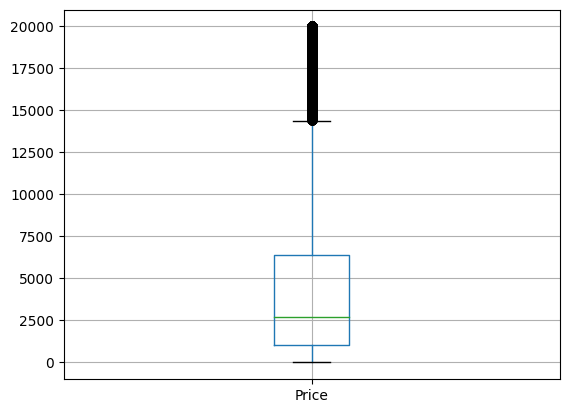

In [8]:
plt.ylim([-1000,21000])
data.boxplot(column='Price');

**Although values above 15000 fall outside the upper range of the chart and value 0 falls within the lower range, we cannot discard the upper values from a common sense point of view because 20,000 euros is an adequate price for a car. It is necessary to find the edge of the lower range, starting from which it will be necessary to discard these values, because they do not reflect actual value.**

**Additionally, we will check what percentage of the data contains zero value.**

In [9]:
data[(2010 < data['RegistrationYear']) & (data['Price'] < 500)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN
35,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no
79,150,NaN,2016,manual,75,astra,150000,3,petrol,opel,yes
111,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN
260,450,NaN,2016,manual,0,NaN,150000,3,petrol,mitsubishi,no
...,...,...,...,...,...,...,...,...,...,...,...
353835,400,NaN,2017,manual,60,polo,150000,0,petrol,volkswagen,NaN
353895,350,NaN,2016,manual,60,3_reihe,150000,10,NaN,peugeot,no
354098,250,NaN,2016,manual,0,3er,150000,5,petrol,bmw,yes
354107,395,NaN,2016,manual,60,golf,150000,12,petrol,volkswagen,NaN


In [10]:
data[data['Price'] == 0].shape[0] / data.shape[0]

0.03000629027048163

**Only 3% of data with zero value, not a critical amount for discarding it rather than restoring it, because zero values are most likely missing values.**

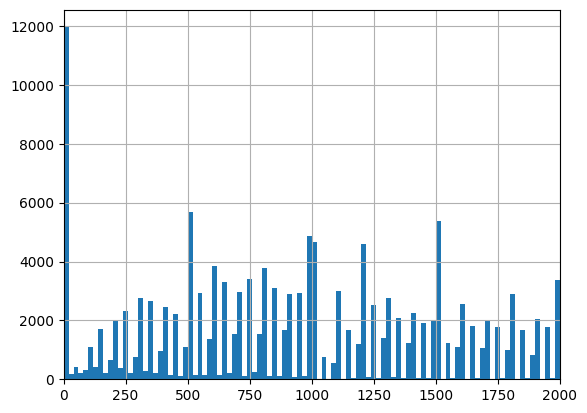

In [11]:
plt.xlim([0, 2000])
data['Price'].hist(bins=1000);

**Using the filtered data as an example, we see that there is a large number of cars in the data, newer than 2010, with a price below 500 euros, which, of course, is an error and incorrect data. The source data obviously contains a large amount of erroneous data that needs to be discarded.**

In [12]:
data = data[data['Price'] > 500]
data.shape[0] / initial_rows

0.8791993656329984

**Almost 88% of the data remained after deletion.**

**Let's see how many percent of all data contain a zero month value.**

In [13]:
data[data['RegistrationMonth'] == 0]['RegistrationMonth'].count() / data['RegistrationMonth'].count()

0.07543627090682081

**About 7.5% of all data contain a zero month value. Most likely, in this case, a zero value is analogous to a gap in the data.**

**From the point of view of common sense, the cost of a car is more influenced by the year of manufacture than the month. In rare exceptional cases, restyling of a specific car model may be released in the same year of manufacture, called transitional. Therefore, we will exclude this attribute from the data, leaving only the attribute responsible for the year of manufacture of the car.**

In [14]:
data = data.drop(['RegistrationMonth'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


**Now let's take a closer look at the values of the `Power` attribute and cut off anomalous values from the data.**

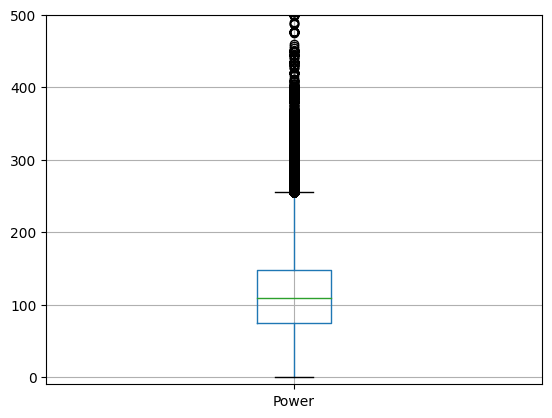

In [15]:
plt.ylim([-10, 500])
data.boxplot(['Power']);

**From the web search I determined that the lowest-power car has 5 hp, respectively, everything below 5 hp. - are anomalous values and must be discarded. In this case, we will first estimate which part of the data from this filter corresponds to the value of the `Power` attribute equal to zero.**

In [16]:
data[(0 == data['Power'])].shape[0] / data[(5 > data['Power'])].shape[0]

0.9978021978021978

**Almost 99.8% of the filtered data for the `Power` attribute value less than 5 corresponds to the value 0.**

**Let us now estimate what percentage of the data has a zero value for this characteristic out of all data.**

In [17]:
data[(0 == data['Power'])].shape[0] / data.shape[0]

0.08743071180282513

**About 8.7%. We can consider this data as gaps, and in order not to lose such a large percentage of the data, we will fill these gaps with the median value for each car model below, in the part of the work where we work with gaps.**

**We will first remove data where the value of this attribute is less than 5 but greater than 0. We will work with zero values below.**

In [18]:
data = data[(data['Power'] >= 5) | ((data['Power'] == 0))]
data.shape[0] / initial_rows

0.8790300505969766

**Almost 88% of the data remained after deletion.**

**Let’s check for the percentage of complete duplicates in the data filtered by the preliminary steps above.**

In [19]:
data.duplicated().sum() / data.shape[0]

0.1282692511420509

**We will remove complete duplicates.**

In [20]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [21]:
data.shape[0] / initial_rows

0.7662775242755433

**Remaining data - 76.6% of the original quantity.**

**Now let’s check some signs for implicit duplicates.**

In [22]:
for column in ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']:
    print(data.groupby([column])[column].count())
    print()

VehicleType
bus            24759
convertible    17380
coupe          13151
other           2547
sedan          71353
small          55832
suv            10423
wagon          51473
Name: VehicleType, dtype: int64

Gearbox
auto       56061
manual    204401
Name: Gearbox, dtype: int64

FuelType
cng            489
electric        77
gasoline     81998
hybrid         212
lpg           4572
other          106
petrol      162709
Name: FuelType, dtype: int64

Brand
alfa_romeo         1846
audi              23599
bmw               29454
chevrolet          1535
chrysler           1152
citroen            4224
dacia               817
daewoo              375
daihatsu            537
fiat               6987
ford              18049
honda              2317
hyundai            3068
jaguar              453
jeep                594
kia                2102
lada                188
lancia              337
land_rover          488
mazda              4420
mercedes_benz     27314
mini               2812
mitsubishi

**No implicit duplicates were identified among the above features.**

**Check for the number of gaps in each attribute as a proportion of the total number of objects.**

In [23]:
data.isna().mean()

Price               0.000000
VehicleType         0.090692
RegistrationYear    0.000000
Gearbox             0.040815
Power               0.000000
Model               0.048644
Kilometer           0.000000
FuelType            0.078742
Brand               0.000000
Repaired            0.177801
dtype: float64

**The largest number of omissions is in the `Repaired` feature - almost 17% of the total number of objects. This sign is important because affects the cost of the car.**

**In second place are gaps in the `VehicleType` feature, there are 9%.**

**There are about 4% gaps in the `Gearbox` feature.**

**As previously noted, there are gaps in the `Power` features, which are expressed as zero values.**

**As for the gaps in the `Model` attribute, this data cannot be restored using the remaining features, so they can be deleted.**

**There are about 8% gaps in the `FuelType` feature.**

**Let's remove the gaps in the `Model` feature below.**

In [24]:
data = data.dropna(subset=['Model'])
data.shape[0] / initial_rows

0.7290028190953498

**Almost 73% of the original data remains.**

**Replace the gaps in the car body type with the most numerous value for a given model of a given brand among the data.**

In [25]:
val = data.groupby(['Model', 'Brand'])['VehicleType'].transform(lambda x: x.mode().iat[0])
data['VehicleType'] = data['VehicleType'].fillna(val)
data['VehicleType'].isna().sum()

0

**We will proceed in the same way to fill in the gaps in the features of fuel type and gearbox type.**

In [26]:
val = data.groupby(['Model', 'Brand'])['FuelType'].transform(lambda x: x.mode().iat[0])
data['FuelType'] = data['FuelType'].fillna(val)

val = data.groupby(['Model', 'Brand'])['Gearbox'].transform(lambda x: x.mode().iat[0])
data['Gearbox'] = data['Gearbox'].fillna(val)

data.isna().mean()

Price               0.000000
VehicleType         0.000000
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.000000
Brand               0.000000
Repaired            0.166365
dtype: float64

**To fill in the gaps in the `Repaired` feature, in the same way, we will first remove those lines with missing values, where the model is unique and there is no way to rely on any statistics on repairs of this model.**

In [27]:
#create a new df, grouping the original one by the number of models, where there is a pass in Repaired
df_temp = data[data['Repaired'].isna()]['Model'].value_counts(ascending=True).to_frame()

#create a list of those models that are unique
temp_list = df_temp[df_temp['Model'] == 1].index.to_list()

#output the row data from the source df
df_chosen_rows = data[(data['Repaired'].isna()) & (data['Model'].isin(temp_list))].copy()
df_chosen_rows

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
27949,1050,small,1998,manual,103,rangerover,150000,petrol,rover,NaN
164289,8000,wagon,2012,manual,90,lodgy,125000,gasoline,dacia,NaN
234296,3800,wagon,1978,manual,0,serie_1,30000,gasoline,land_rover,NaN
309856,18555,suv,2010,manual,163,amarok,70000,gasoline,volkswagen,NaN


In [28]:
#delete the row data from the source df through the index
data = data.drop(df_chosen_rows.index)
data[(data['Repaired'].isna()) & (data['Model'].isin(temp_list))]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


**Necessary lines have been removed. Now let's fill in the gaps in the `Repair` feature with the value most often found for a given car model.**

In [29]:
val = data.groupby(['Model', 'Brand'])['Repaired'].transform(lambda x: x.mode().iat[0])
data['Repaired'] = data['Repaired'].fillna(val)
data.isna().mean()

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
dtype: float64

**Let's replace the gaps in the vehicle power feature, which are expressed by a zero value in the data, with the median value for a given model of a given brand among the data.**

In [30]:
data.loc[data['Power'] == 0, 'Power'] = data.groupby(['Model', 'Brand'])['Power'].transform('median')
data[data['Power'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


In [31]:
data.isna().mean()

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
dtype: float64

**There are no more gaps in the data.**

In [32]:
data.shape[0] / initial_rows

0.7289915314262816

**In total, data loss after preprocessing was about 27%.**

**Change the type of the `Power` feature to integer.**

In [33]:
data['Power'] = data['Power'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258332 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             258332 non-null  int64 
 1   VehicleType       258332 non-null  object
 2   RegistrationYear  258332 non-null  int64 
 3   Gearbox           258332 non-null  object
 4   Power             258332 non-null  int64 
 5   Model             258332 non-null  object
 6   Kilometer         258332 non-null  int64 
 7   FuelType          258332 non-null  object
 8   Brand             258332 non-null  object
 9   Repaired          258332 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


**To simplify the work of the models later, we will convert the categorical feature `RegistrationYear` into a numeric one - the age of the car or `Age`.**

In [34]:
data['Age'] = datetime.now().year - data['RegistrationYear']
data = data.drop(['RegistrationYear'], axis = 1)
data.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
2,9800,suv,auto,163,grand,125000,gasoline,jeep,no,19
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,22
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,15
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes,28
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no,19


**After preprocessing, we will check the correlation of features.**

In [36]:
data.corr(numeric_only=True)

,Price,Power,Kilometer,Age
Price,1.000000,0.127155,-0.372874,-0.415412
Power,0.127155,1.000000,0.034756,-0.013039
Kilometer,-0.372874,0.034756,1.000000,0.259965
Age,-0.415412,-0.013039,0.259965,1.000000


**We see a slight inverse correlation between the target feature and the age of the car. It would be even higher if it were possible to obtain more correct data from a logical point of view, but as we remember, above we found that the cost of cars with a fairly new year of manufacture was underestimated, which does not correspond to reality.**

## Model training

### Dividing data into samples

**Our initial dataset is divided into samples - training and testing. We will not create a separate validation sample, because Next we will use GridSearchCV with cross-validation.**

**Because Our data contains categorical features, then for simple models to further work with them, it is necessary to encode them. We will encode categorical features using the OneHotEncoder method for linear regression and the OrdinalEncoder method for decision tree regression. For LightGBM, features do not need to be encoded separately.**

In [38]:
#divide the source dataset into features and target feature
target = data['Price']
features = data.drop('Price', axis=1)

#split the features and target features into training and test samples in a ratio of 75/25
features_train, features_test, target_train, target_test = train_test_split(
     features, target, test_size=0.25, random_state=1)

#highlight lists of numerical features and categorical features
num_cols = ['Power', 'Kilometer', 'Age']
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


features_train_linreg = features_train.copy()
features_test_linreg = features_test.copy()
ct_linreg = ColumnTransformer([
    ("scaling", StandardScaler(), num_cols),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)])
ct_linreg.fit(features_train_linreg)
features_train_linreg = ct_linreg.transform(features_train_linreg)
features_test_linreg = ct_linreg.transform(features_test_linreg)

features_train_tree = features_train.copy()
features_test_tree = features_test.copy()
ct_tree = ColumnTransformer([
    ("scaling", StandardScaler(), num_cols),
    ("onehot", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), cat_cols)])
ct_tree.fit(features_train_tree)
features_train_tree = ct_tree.transform(features_train_tree)
features_test_tree = ct_tree.transform(features_test_tree)

features_train_lgb = features_train.copy()
features_test_lgb = features_test.copy()
features_train_lgb[cat_cols] = features_train_lgb[cat_cols].astype('category')
features_test_lgb[cat_cols] = features_test_lgb[cat_cols].astype('category')

print(features_train_linreg.shape)
print(features_test_linreg.shape)

print(features_train_tree.shape)
print(features_test_tree.shape)

print(features_train_lgb.shape)
print(features_test_lgb.shape)

(193749, 310)
(64583, 310)
(193749, 9)
(64583, 9)
(193749, 9)
(64583, 9)


**For the current task, we will select three models for comparison - linear regression, decision tree regression and LightGBM. To find a set of hyperparameters that give the best result of the RMSE metric, we will use the GridSearchCV tool, which also uses cross-validation in its mechanism.**

### Linear regression

In [39]:
model_linreg = LinearRegression()
cv_linreg = cross_validate(
                model_linreg,
                features_train_linreg,
                target_train,
                scoring='neg_root_mean_squared_error',
                cv=3,
                n_jobs=-1)
lin_reg_rmse_train = round(-1*max(cv_linreg['test_score']), 3)
lin_reg_fit_time_train = round(cv_linreg['fit_time'].mean())
lin_reg_score_time_train = round(cv_linreg['score_time'].mean())
print('RMSE for LinReg on training set =', lin_reg_rmse_train)
print('LinReg training time on training set =', lin_reg_fit_time_train)
print('LinReg prediction time on training set =', lin_reg_score_time_train)

RMSE for LinReg on training set = 26482508149.846
LinReg training time on training set = 11
LinReg prediction time on training set = 0


### Decision tree regression

In [40]:
model_tree = DecisionTreeRegressor(random_state=1)

param_tree = {'max_depth':range(1,10,2),
              'criterion':['friedman_mse'],
              'min_samples_split':range(2,10,2),
              'max_depth': range(1,10,2)}
gridsearch_tree = GridSearchCV(
    estimator=model_tree,
    param_grid=param_tree,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1)
gridsearch_tree.fit(features_train_tree, target_train)
#metric in gridsearchCV - negative RMSE value, to get RMSE you need to multiply by -1

tree_rmse_train = round((-1 * gridsearch_tree.best_score_), 3)
tree_fit_time_train = round(
    pd.DataFrame(gridsearch_tree.cv_results_).iloc[gridsearch_tree.best_index_]['mean_fit_time'], 3)
tree_score_time_train = round(
    pd.DataFrame(gridsearch_tree.cv_results_).iloc[gridsearch_tree.best_index_]['mean_score_time'], 3)
print('Best RMSE metric value for the DecTreeReg model on the training set =', tree_rmse_train)
print('Training time for the DecTreeReg model with the best score on the training set =', tree_fit_time_train)
print('Prediction time DecTreeReg with the best score on the training set =', tree_score_time_train)

Best RMSE metric value for the DecTreeReg model on the training set = 2105.16
Training time for the DecTreeReg model with the best score on the training set = 0.51
Prediction time DecTreeReg with the best score on the training set = 0.01


### LightGBM Gradient Boosting Model

In [41]:
model_lgb = lgb.LGBMRegressor(num_threads=4, random_state=1)

param_lgb = {'learning_rate': [0.3, 0.1],
             'n_estimators': [50, 100],
             'verbose': [-1]}
gridsearch_lgb = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_lgb,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=-1)
gridsearch_lgb.fit(features_train_lgb, target_train)
#metric in gridsearchCV - negative RMSE value, to get RMSE you need to multiply by -1

lgb_rmse_train = round(-1 * gridsearch_lgb.best_score_, 3)
lgb_fit_time_train = round(
    pd.DataFrame(gridsearch_lgb.cv_results_).iloc[gridsearch_lgb.best_index_]['mean_fit_time'], 3)
lgb_score_time_train = round(
    pd.DataFrame(gridsearch_lgb.cv_results_).iloc[gridsearch_lgb.best_index_]['mean_score_time'], 3)
print('Best RMSE metric value for LGBM model on training set =', lgb_rmse_train)
print('LGBM model training time with the best score on the training set =', lgb_fit_time_train)
print('LGBM prediction time with the best score on the training set =', lgb_score_time_train)

Best RMSE metric value for LGBM model on training set = 1664.048
LGBM model training time with the best score on the training set = 1.891
LGBM prediction time with the best score on the training set = 0.354


## Model analysis

In [42]:
try:
    data_models = [[lin_reg_fit_time_train, tree_fit_time_train, lgb_fit_time_train],
                   [lin_reg_score_time_train, tree_score_time_train, lgb_score_time_train],
                   [lin_reg_rmse_train, tree_rmse_train, lgb_rmse_train]]
except:
    data_models = [[lin_reg_fit_time_train, tree_fit_time_train, 'NaN'],
                   [lin_reg_score_time_train, tree_score_time_train, 'NaN'],
                   [lin_reg_rmse_train, tree_rmse_train, 'NaN']]

pd.DataFrame(data_models,
             columns=['lin_reg', 'dec_tree_reg', 'lgbm_reg'],
             index=['fit_time', 'score_time', 'train_rmse'])

,lin_reg,dec_tree_reg,lgbm_reg
fit_time,1.100000e+01,0.51,1.891
score_time,0.000000e+00,0.01,0.354
train_rmse,2.648251e+10,2105.16,1664.048


## CONCLUSION

**The best value of the RMSE metric was obtained on the LGBM model, the best training and prediction time was shown by the decision tree regression model.**

**Because the criteria that are important to the customer are:**

**- quality of prediction;**

**- model training time;**

**- model prediction time.**

**Based on a combination of factors, it is better to choose the LGBM model, since its prediction quality is much higher, and the training time, although longer than that of the other model, is quite adequate.**

**Let’s now check the LGBM model with the best score on the test sample.**

In [43]:
start_predict_lgb = time.time()
predict_lgb = gridsearch_lgb.best_estimator_.predict(features_test_lgb)
end_predict_lgb = time.time()
print('RMSE for LGBM on test set =',
       round(mean_squared_error(target_test, predict_lgb, squared=False),3))
print('LGBM prediction time on test set =',
       round(end_predict_lgb - start_predict_lgb, 3))

RMSE for LGBM on test set = 1654.014
LGBM prediction time on test set = 0.412


## Checking models for adequacy

**Let's check the selected models for adequacy using the Dummy Model from the sklearn class, having previously imported it in the first step.**

**The check is that the quality of the trained model chosen above is higher than the quality of the Dummy model, which predicts the result without relying on the features of the training set.**

In [44]:
model_dummy = DummyRegressor()
parameters_dummy = {'strategy':['mean', 'median', 'constant'],
                            'constant':(500,20000,500)}
gridsearch_dummy = GridSearchCV(
    estimator=model_dummy,
    param_grid=parameters_dummy,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1)
gridsearch_dummy.fit(features_train, target_train)
print('Best RMSE metric value for the Dummy model on the training set =',
       (-1 * gridsearch_dummy.best_score_))

Best RMSE metric value for the Dummy model on the training set = 4578.517038689584


In [45]:
predict_dummy = gridsearch_dummy.best_estimator_.predict(features_test)
print('Best RMSE metric value for the Dummy model on the test set =',
       mean_squared_error(target_test, predict_dummy, squared=False))

Best RMSE metric value for the Dummy model on the test set = 4571.226809875121


### CONCLUSION

**As a result, using the Dummy model, it was possible to obtain the best model quality with RMSE equal to 4571 on the test set, which is significantly lower than the best result of the selected and trained linear regression, decision tree regression and LightGBM models. Which proves the adequacy of the model we found and selected.**